# Predict Adverse Drug Reactions with the LINCS L1000 data

---


## _Zichen Wang, Avi Ma'ayan_

<img src="http://lincs-dcic.org/images/dcic-logo/DCIC_500x375_cropped.png" style="float: right; width: 100px;"/>

#### BD2K-LINCS Data Coordination and Integration Center

#### CMap Workshop - Dec. 4th, 2018 

---

## Table of content 

- [TBA]()
- ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division
import os, sys
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='white')

In [3]:
import plots
import gctx_utils

# 1. Prepare datasets for machine learning 

## 1.1. Prepare level 5 signatures for drugs/compounds

- load metadata for genes and signatures

In [4]:
gctx5 = h5py.File('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', 'r')

In [5]:
gene_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt.gz', 
                           compression='gzip',
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print('Number of landmark genes', len(LM_GENE_IDS))

(12328, 4)
Number of landmark genes 978


In [6]:
sig_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
print(sig_info_df.shape)

# Get compound treatment signatures in PC3 cell line
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
print(sig_info_df.shape)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



(473647, 11)
(23123, 11)


In [7]:
sig_info_df.nunique()

pert_id           11150
pert_iname        10661
pert_type             1
cell_id               1
pert_dose          1392
pert_dose_unit        1
pert_idose           27
pert_time             2
pert_time_unit        1
pert_itime            2
distil_id         23123
dtype: int64

## 1.2. Load chemical fingerprints for drugs/compounds

In [8]:
drugs_fp_df = pd.read_csv('data/MACCS_bitmatrix.csv.gz', 
                         compression='gzip',
                         ).set_index('pert_id')
drugs_fp_df.shape

(41774, 166)

In [9]:
drugs_fp_df.head()

,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
BRD-A00051892,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,1
BRD-A00100033,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
BRD-A00150179,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
BRD-A00214921,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 1.3. Load drug-ADR connections from SIDER

In [10]:
sider_df = pd.read_csv('data/SIDER_PTs.csv.gz', 
                      compression='gzip'
                      ).set_index('pert_id')
sider_df.shape

(834, 3165)

In [11]:
sider_df.head()

,Vulvovaginal disorder,Cardiac failure,Thalassaemia,Peritoneal haemorrhage,Cardiac murmur,Judgement impaired,Jaundice,Plasmodium falciparum infection,Influenza like illness,Ingrown hair,...,Phobia,Rash maculo-papular,Oesophageal candidiasis,Blepharitis,Muscle contractions involuntary,Echolalia,Dysplasia,Hypermagnesaemia,Ileus,Blood bilirubin increased
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00546892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00827783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01320529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01636364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01643550,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.4. Find drugs/compounds that are shared among the three datasets

In [12]:
from matplotlib_venn import venn3, venn2

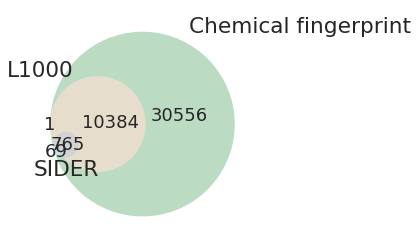

In [13]:
venn3([set(sig_info_df.pert_id), set(drugs_fp_df.index), set(sider_df.index)],
      ('L1000', 'Chemical fingerprint', 'SIDER')
     )

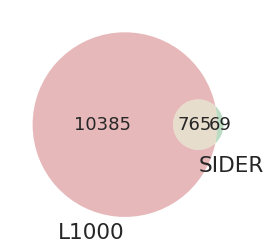

In [14]:
venn2([set(sig_info_df.pert_id), set(sider_df.index)],
      ('L1000', 'SIDER')
     )

In [15]:
shared_drugs = set(sig_info_df.pert_id) & set(drugs_fp_df.index) & set(sider_df.index)
shared_drugs = sorted(shared_drugs)
print(len(shared_drugs))

765


In [16]:
sig_info_df = sig_info_df.loc[sig_info_df['pert_id'].isin(shared_drugs)]
sig_info_df.shape

(2723, 11)

In [17]:
# Retrieve L1000 signatures from the level 5 data
X_L1000 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                                  cids=sig_info_df.index.values.astype(np.str))
X_L1000.shape

(2723, 978)

In [18]:
from sklearn import decomposition

In [19]:
pca = decomposition.PCA(n_components=50)
X_L1000_pca = pca.fit_transform(X_L1000)
X_L1000_pca.shape

(2723, 50)

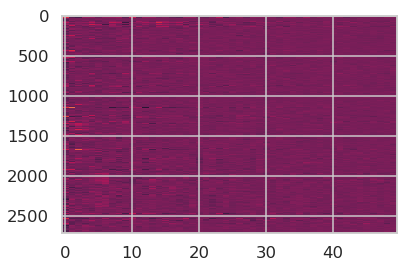

In [20]:
plt.imshow(X_L1000_pca, aspect='auto');

In [21]:
# Subset chemical fingerprint matrix
X_CS = drugs_fp_df.loc[sig_info_df['pert_id']].values
# remove zero features
X_CS = X_CS[:, X_CS.sum(axis=0) > 0]
X_CS.shape

(2723, 154)

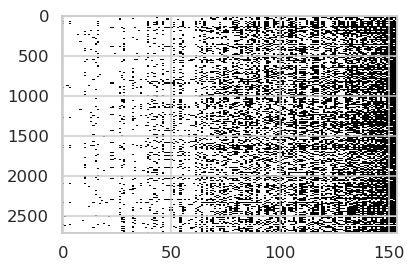

In [22]:
plt.imshow(X_CS, aspect='auto', cmap='binary');

In [23]:
pca = decomposition.TruncatedSVD(n_components=50)
X_CS_pca = pca.fit_transform(X_CS)

In [24]:
# Subset SIDER matrix
Y = sider_df.loc[sig_info_df['pert_id']].values
Y.shape

(2723, 3165)

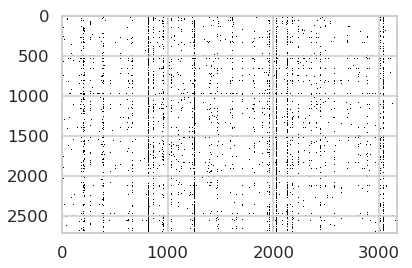

In [25]:
plt.imshow(Y, aspect='auto', cmap='binary');

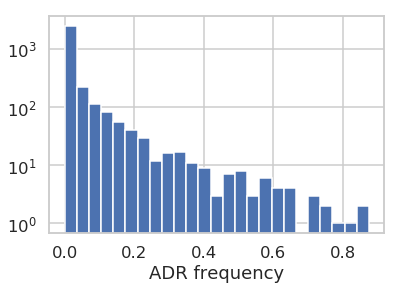

In [26]:
# Examine label (ADR) frequencies
freqs_ADR = Y.mean(axis=0)
plt.hist(freqs_ADR, bins=25, log=True)
plt.xlabel('ADR frequency');

In [27]:
# Examine frequent ADRs
ADRs_freq_df = pd.DataFrame({'frequency': freqs_ADR}, 
                            index=sider_df.columns)

ADRs_freq_df.sort_values('frequency', ascending=False).head(10)

,frequency
Nausea,0.874770
Rash,0.854939
Vomiting,0.827029
Headache,0.791039
Pain,0.762027
Diarrhoea,0.742196
Oedema,0.723467
Dizziness,0.719427
Pruritus,0.710981
Hypersensitivity,0.651855


In [28]:
# Examine infrequent ADRs
ADRs_freq_df.query('frequency > 0').sort_values('frequency').head(10)

,frequency
Brain abscess,0.000367
Hepatoblastoma,0.000367
Serum sickness-like reaction,0.000367
Ear pruritus,0.000367
Ovarian neoplasm,0.000367
Haemorrhagic anaemia,0.000367
Renal cell carcinoma,0.000367
Tooth deposit,0.000367
Ovarian germ cell teratoma benign,0.000367
Hypercoagulation,0.000367


In [29]:
# Exclude ADRs that are too infrequent or frequent
mask_ADR_to_predict = (freqs_ADR > 0.2) & (freqs_ADR < 0.7)

Y = Y[:, mask_ADR_to_predict]
Y.shape

(2723, 143)

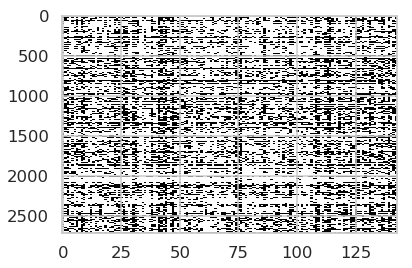

In [30]:
plt.imshow(Y, aspect='auto', cmap='binary');

# 2. Train and validate multi-label classification model to predict ADRs

In [31]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from skmultilearn.ensemble import RakelD
from skmultilearn.adapt import MLkNN, MLARAM
from sklearn import linear_model, ensemble, metrics
from sklearn.model_selection import GroupKFold

In [32]:
def cross_validate_ml_clf(ml_clf, cv, X, Y, groups):
    '''
    
    groups: the same group (signatures of the same compound) will not appear 
        in two different folds to avoid over-estimation of predictive performance.
    '''
    
    i = 0 
    scores_df = pd.DataFrame(columns=['hamming_loss', 'accuracy', 'F1'])
    label_aurocs = np.zeros(Y.shape[1])
    
    for train_idx, valid_idx in cv.split(X, Y, groups):
        X_train, X_valid = X[train_idx], X[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]
        print(X_train.shape, Y_train.shape)
        print(X_valid.shape, Y_valid.shape)
        ml_clf.fit(X_train, Y_train)

        Y_valid_pred = ml_clf.predict(X_valid)
        if type(Y_valid_pred) != np.ndarray:
            Y_valid_pred = Y_valid_pred.toarray() # convert sparse matrix to dense
        
        hamming_loss = metrics.hamming_loss(Y_valid, Y_valid_pred)
        acc = metrics.accuracy_score(Y_valid.ravel(), Y_valid_pred.ravel())
        f1 = metrics.f1_score(Y_valid, Y_valid_pred, average='micro')
        print('Fold %d, hamming loss=%.4f, accuracy=%.4f, F1=%.4f'% (i, hamming_loss, acc, f1))
        scores_df.loc[i] = [hamming_loss, acc, f1]

        Y_valid_pred_probas = ml_clf.predict_proba(X_valid)
        if type(Y_valid_pred_probas) != np.ndarray:
            Y_valid_pred_probas = Y_valid_pred_probas.toarray() # convert sparse matrix to dense
        
        # Per-label AUROC scores        
        aurocs = metrics.roc_auc_score(Y_valid, Y_valid_pred_probas, average=None)
        label_aurocs += aurocs / cv.n_splits
        
        i += 1
    return scores_df, label_aurocs

In [33]:
cv = GroupKFold(n_splits=3)

## 2.1. Examine the performances of a few multi-label classification algorithms

In [34]:
rf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=5)
br_rf = BinaryRelevance(
    classifier=rf
)

In [36]:
scores_df, label_aurocs = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3364, accuracy=0.6636, F1=0.3541
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3256, accuracy=0.6744, F1=0.3709
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3450, accuracy=0.6550, F1=0.3681


In [37]:
mlaram = MLARAM()

In [38]:
scores_df2, label_aurocs2 = cross_validate_ml_clf(mlaram, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.5006, accuracy=0.4994, F1=0.4598
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.4180, accuracy=0.5820, F1=0.4147
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3175, accuracy=0.6825, F1=0.4118


In [39]:
rakeld = RakelD(base_classifier=rf,
               base_classifier_require_dense=[True, True],
               labelset_size=3)

In [40]:
scores_df3, label_aurocs3 = cross_validate_ml_clf(rakeld, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3424, accuracy=0.6576, F1=0.3014
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3260, accuracy=0.6740, F1=0.3355
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3490, accuracy=0.6510, F1=0.3262


In [41]:
cc_rf = ClassifierChain(
    classifier=rf
)

In [42]:
scores_df4, label_aurocs4 = cross_validate_ml_clf(cc_rf, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3466, accuracy=0.6534, F1=0.0945
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3212, accuracy=0.6788, F1=0.1170
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3617, accuracy=0.6383, F1=0.1100


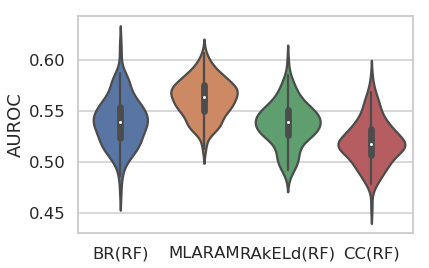

In [43]:
ax = sns.violinplot(data=pd.DataFrame({'BR(RF)': label_aurocs, 
                                  'MLARAM': label_aurocs2,
                                  'RAkELd(RF)': label_aurocs3,
                                  'CC(RF)': label_aurocs4,
                                 }))
ax.set_ylabel('AUROC');

## 2.2. Cross-validate classifier on different subset of features 
- L1000 signatures
- fingerprints
- combinations

In [44]:
# mlaram = MLARAM(threshold=0.2)
mlaram = MLARAM()

In [40]:
scores_df_GE, aurocs_GE = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3342, accuracy=0.6658, F1=0.3556
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3240, accuracy=0.6760, F1=0.3725
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3454, accuracy=0.6546, F1=0.3669


In [45]:
scores_df_GE, aurocs_GE = cross_validate_ml_clf(mlaram, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.5006, accuracy=0.4994, F1=0.4598
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.4180, accuracy=0.5820, F1=0.4147
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3175, accuracy=0.6825, F1=0.4118


In [38]:
scores_df_CS, aurocs_CS = cross_validate_ml_clf(br_rf, cv, X_CS_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3004, accuracy=0.6996, F1=0.4257
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.2618, accuracy=0.7382, F1=0.4876
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.2677, accuracy=0.7323, F1=0.5345


In [46]:
scores_df_CS, aurocs_CS = cross_validate_ml_clf(mlaram, cv, X_CS_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.4216, accuracy=0.5784, F1=0.4016
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.0130, accuracy=0.9870, F1=0.9797
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.0010, accuracy=0.9990, F1=0.9986


In [39]:
scores_df_GECS, aurocs_GECS = cross_validate_ml_clf(br_rf, cv, np.hstack((X_L1000_pca, X_CS_pca)), Y,
                                                   groups=sig_info_df.pert_id)

(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 0, hamming loss=0.2995, accuracy=0.7005, F1=0.4203
(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 1, hamming loss=0.2637, accuracy=0.7363, F1=0.4838
(1816, 100) (1816, 143)
(907, 100) (907, 143)
Fold 2, hamming loss=0.2725, accuracy=0.7275, F1=0.5183


In [47]:
scores_df_GECS, aurocs_GECS = cross_validate_ml_clf(mlaram, cv, np.hstack((X_L1000_pca, X_CS_pca)), Y,
                                                   groups=sig_info_df.pert_id)

(1815, 100) (1815, 143)
(908, 100) (908, 143)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
ax = sns.violinplot(data=pd.DataFrame({'GE': aurocs_GE, 
                                  'CS': aurocs_CS,
                                  'GE + CS': aurocs_GECS,
                                 }))
ax.set_ylabel('AUROC');

In [46]:
auroc_df = pd.DataFrame({'auroc': aurocs_GECS}, index=sider_df.columns[mask_ADR_to_predict])
# Most predictable ADRs
auroc_df.sort_values('auroc', ascending=False).head()

,auroc
Anaphylactoid reaction,0.747516
Eosinophilia,0.746875
Neutropenia,0.743902
Agranulocytosis,0.743180
Stomatitis,0.739922


In [47]:
# Least predictable ADRs
auroc_df.sort_values('auroc').head()

,auroc
Discomfort,0.571963
Shock,0.602563
Dry skin,0.618516
Respiratory tract infection,0.620866
Bronchospasm,0.620998
